### Network Deconvolution example

pre-requsits: caffe deconvolution / unpooling layer

model-prototxt: http://10.202.211.120:2596/PBrain/models/vgg/vgg_layer16_deploy_fcn_deconv.prototxt

model-weight: http://10.202.211.120:2596/PBrain/models/vgg/vgg_layer16_fcn.caffemodel

Start deconvolution,  objects/images/ukbench04164.jpg
Done load image


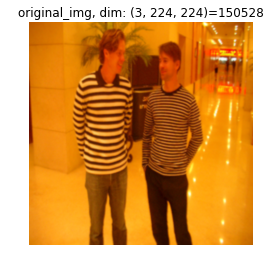

layer pool1, dim: (64, 112, 112)=802816, mean: -170.525360107, min_val: -80166.6171875, max_val: 86565.2890625


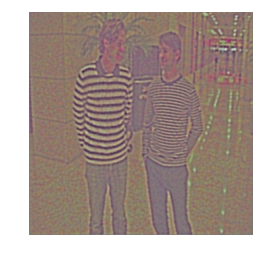

layer pool2, dim: (128, 56, 56)=401408, mean: -1321.98474121, min_val: -682334.4375, max_val: 686802.5625


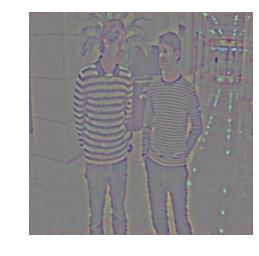

layer pool3, dim: (256, 28, 28)=200704, mean: -1913.87609863, min_val: -996087.6875, max_val: 897066.8125


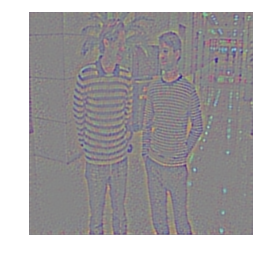

layer pool4, dim: (512, 14, 14)=100352, mean: -16.9486618042, min_val: -93596.3515625, max_val: 79081.34375


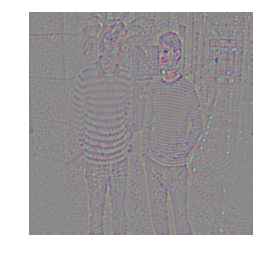

layer pool5, dim: (512, 7, 7)=25088, mean: 113.194206238, min_val: -722.375671387, max_val: 958.762634277


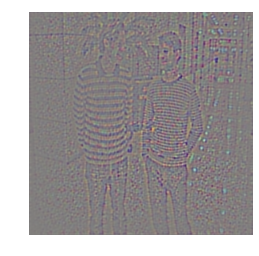

layer fc6_conv, dim: (4096, 1, 1)=4096, mean: 112.880271912, min_val: -896.555847168, max_val: 967.414123535


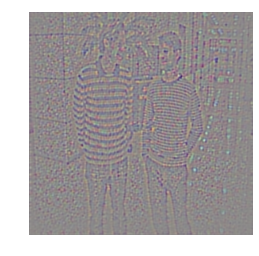

layer relu6_conv, dim: (4096, 1, 1)=4096, mean: 114.684204102, min_val: 59.9182929993, max_val: 168.001266479


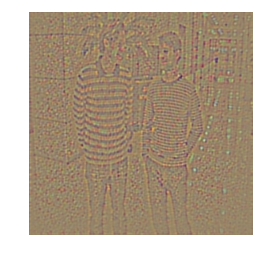

Done deconvolution


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image

CAFFE_ROOT = '/works/caffe-recurrent/'
import sys
sys.path.insert(0, CAFFE_ROOT + 'python')
import caffe;
from caffe import caffe_utils as utils

MODEL_ROOT = '/storage/models/'
MODEL_VGG_DEPLOY_FILE = '%s/vgg/vgg_layer16_deploy_fcn_deconv.prototxt' % MODEL_ROOT
MODEL_VGG_WEIGHT_FILE = '%s/vgg/vgg_layer16_fcn.caffemodel' % MODEL_ROOT

MODEL_ORIGINAL_INPUT_SIZE = 224, 224
MODEL_MEAN_VALUE = np.float32([103.939, 116.779, 123.68]) # vgg-16

DATASET_ROOT = '/storage/CDVS_Dataset/'
DATASET_LIST = 'database_images.txt'

caffe.set_mode_cpu()
net_vgg   = caffe.Classifier( MODEL_VGG_DEPLOY_FILE, MODEL_VGG_WEIGHT_FILE, mean = MODEL_MEAN_VALUE, channel_swap = (2, 1, 0) )
src_vgg = net_vgg.blobs['data']
src_vgg.reshape(1, 3, MODEL_ORIGINAL_INPUT_SIZE[0], MODEL_ORIGINAL_INPUT_SIZE[1])

filenames=['%s' % entry.strip().split(' ')[0] for entry in open('%s/%s' % (DATASET_ROOT, DATASET_LIST))]
#filenames = ['paintings/Queries/smvs_museum_paintings_Canon_064.jpg']
#filenames = ['objects/images/ukbench02146.jpg']
#filenames = ['paintings/Reference/smvs_museum_paintings_060.jpg']
#filenames = ['objects/images/ukbench09584.jpg']
filenames = ['objects/images/ukbench04164.jpg']
#filenames = ['objects/images/ukbench04808.jpg']
#filenames = ['objects/images/ukbench00560.jpg']
#filenames = ['graphics/original/print/Queries/smvs_print_Droid_055.jpg']
#filenames = ['graphics/original/print/Reference/smvs_print_Canon_046.jpg']

print 'Start deconvolution, ', filenames[0]
im = utils.load_image( '%s/%s' %(DATASET_ROOT, filenames[0]) )
im = im.resize( MODEL_ORIGINAL_INPUT_SIZE, PIL.Image.ANTIALIAS )
im = utils.preprocess(net_vgg, im)
src_vgg.data[:] = im[:]
original_image = PIL.Image.fromarray(np.uint8(utils.deprocess(net_vgg, im)))
original_image_filename = filenames[0].split('/')[-1]
original_image.save('%s/deconv_images/%s.png' % (DATASET_ROOT, original_image_filename))

print 'Done load image'

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['image.interpolation'] = 'bicubic'
plt.rcParams['image.cmap'] = 'gray'
plt.figure();
blob_name = "original_img, dim: {}={}".format(im.shape, np.prod(im.shape))
plt.title(blob_name); plt.axis('off')
plt.imshow(np.uint8(utils.deprocess(net_vgg, im))); plt.show()

end_blob_name  = ['pool1', 'pool2', 'pool3', 'pool4', 'pool5', 'fc6_conv', 'relu6_conv']
copy_to_blob_name= ['deconv2_1', 'deconv3_1', 'deconv4_1', 'deconv5_1', 'fc6_deconv', 'relu6_deconv', 'fc7_deconv']
decon_layer_name = ['unpool1', 'unpool2', 'unpool3', 'unpool4', 'unpool5', 'fc6_deconv', 'relu6_deconv']
iter_idx = [0, 1, 2, 3, 4, 5, 6]
for layer_idx, end_blob, copy_to, deconv_layer in zip(iter_idx, end_blob_name, copy_to_blob_name, decon_layer_name):
    net_vgg.forward(end=end_blob)
    net_vgg.blobs[copy_to].data[...] = np.copy(net_vgg.blobs[end_blob].data)
    net_vgg.forward(start=deconv_layer)
    
    recon = np.copy(net_vgg.blobs['deconv1_1'].data[0])
    recon = utils.deprocess(net_vgg, recon)
    min_val, max_val = recon.flatten().min(), recon.flatten().max()
    print "layer {}, dim: {}={}, mean: {}, min_val: {}, max_val: {}".format( \
            end_blob, net_vgg.blobs[end_blob].data[0].shape, \
            np.prod(net_vgg.blobs[end_blob].data[0].shape), \
            np.mean(recon.flatten()), min_val, max_val)
    recon = (recon - min_val) / (max_val - min_val)
    recon = recon * 255
    recon = np.uint8(np.clip(recon, 0, 255))
    plt.figure()
    plt.axis('off'); plt.imshow(recon); plt.show();
    recon_image = PIL.Image.fromarray(recon)
    image_filename = filenames[0].split('/')[-1]
    recon_image.save('%s/deconv_images/%s_%s.png' % (DATASET_ROOT, image_filename, end_blob_name[layer_idx]))

print 'Done deconvolution'